In [50]:
import numpy as np
from toolz.curried import pipe, curry, identity, merge_with, merge
from toolz.curried import map as map_
import matplotlib.pyplot as plt
import math

%matplotlib inline

# Cross-Entropy Loss Backpropagation

Let $f_{ij}$ be the final scores from the last final layer. $i$ is over the samples ($1$ to $N$) and $j$ is over the categories. The cross-entropy loss is given by,

$$L_D = \frac{\sum_i L_i}{N}$$ 

where $L_D$ is the total loss not including the regularization loss and $L_i$ is the loss for each sample given by,

$$L_i = -\log \left(p_{iy_i} \right)$$

where $p_{ik}$ are the probabilities for each category per sample and $y_i$ are the actual categories per sample. The $p_{ik}$ is given by,

$$p_{ik} = \frac{ e^{f_{ik}} }{ \sum_m e^{f_{im}}}$$

To calculate the backprop,

\begin{align}
\frac{\partial L_i}{ \partial f_{ij}} &= \frac{\partial}{ \partial f_{ij}} \left[ \log\left(p_{iy_i} \right)\right] \\
&=\frac{1}{p_{iy_i}} \frac{\partial}{ \partial f_{ij}} \left[ p_{iy_i}  \right] \\
&=\frac{1}{p_{iy_i} } \left[ p_{iy_i}\delta_{jy_i} - p_{iy_i} p_{ij} \right] \\
&=\delta_{jy_i} - p_{ij}
\end{align}

So,

$$ \frac{\partial L_D}{ \partial f_{ij}} = \frac{1}{N}\left(p_{ij} - \delta_{iy_i}\right)$$

In [61]:
## Example from https://cs231n.github.io/optimization-2/

class Node:
    def __init__(self, *nodes):
        self.nodes = nodes
        self.loss = None
        
    def reset(self):
        self.loss = None
        map_(lambda x: x.reset(), self.nodes)
        
    def calc(self):
        if self.loss is None:
            self.loss = self.f_(*list(map_(lambda x: x.calc(), self.nodes)))
        return self.loss
  
    def backprop(self, dvalue=1.0):
        values = list(map_(lambda x: x.calc(), self.nodes))
        dvalues = self.df_(dvalue, *values)
        list(map_(lambda x: x[0].backprop(x[1]), zip(self.nodes, dvalues)))
    
    def get_dvalues(self):
        return merge(list(map_(lambda x: x.get_dvalues(), self.nodes)))
    
    def df_(self, dvalue, *values):
        return list(map_(lambda x: x * dvalue, self.df(*values)))
    
    def f_(self, *values):
        return self.f(*values)
    
    def __mul__(self, other):
        return Mul(self, other)
    
    def __add__(self, other):
        return Add(self, other)
    
class Leaf(Node):
    def __init__(self, value, name):
        super().__init__()
        self.f = lambda: value
        self.name = name
        self.dvalue = 0.0
    
    def get_dvalues(self):
        return {self: self.dvalue}
    
    def backprop(self, dvalue=1.0):
        self.dvalue += dvalue
    
    def __repr__(self):
        return f'Leaf({self.name})'
    
    def reset(self):
        self.dvalue = 0.0
        self.loss = None
    
class Add(Node):
    f = staticmethod(lambda a, b: a + b)
    df = staticmethod(lambda a, b: (1, 1))
    
class Div(Node):
    f = staticmethod(lambda a, b: a / b)
    df = staticmethod(lambda a, b: (b, -a / b**2))
    
class Mul(Node):
    f = staticmethod(lambda a, b: a * b)
    df = staticmethod(lambda a, b: (b, a))

class Sig(Node):
    f = staticmethod(lambda a: 1 / (1 + math.exp(-a)))
    df = staticmethod(lambda a: (Sig.f(a)**2 * math.exp(-a),))
    
x0 = Leaf(-1, 'x0')
x1 = Leaf(-2, 'x1')
w0 = Leaf(2, 'w0')
w1 = Leaf(-3, 'w1')
w2 = Leaf(-3, 'w2')

out = Sig(w0 * x0 + w1 * x1 + w2 + w0 * x0)
out.reset()
print(out.calc())
print(out.backprop())
print(out.get_dvalues())


0.2689414213699951
None
{Leaf(w0): -0.3932238664829636, Leaf(x0): 0.7864477329659272, Leaf(w1): -0.3932238664829636, Leaf(x1): -0.5898357997244454, Leaf(w2): 0.1966119332414818}


In [62]:
# implement https://cs231n.github.io/neural-networks-case-study/

class Weight(Leaf):
    def __init__(self, N0, N1, name):
        super().__init__(0.01 * np.random.randn(N0, N1), name)
 
class B(Leaf):
    def __init__(self, N, name):
        super().__init__(0.01 * np.zeros((1, N)), name)
        
class NN(Node):
    @staticmethod
    def f(x, w, b):
        return np.dot(x, w) + b
    
    def df_(self, dvalue, x, w, b):
        return (
            np.dot(dvalue, w.T),
            np.dot(x.T, dvalue),
            np.sum(dvalue, axis=0, keepdims=True)
        )

class Loss(Node):
    def __init__(self, y, *nodes):
        self.y = y
        self.reg = 1e-3
        super().__init__(*nodes)
        
    def f_(self, scores, w):
        N = scores.shape[0]
        exp_scores = np.exp(scores)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        correct_logprobs = -np.log(self.probs[range(N), self.y])
        return np.sum(correct_logprobs) / N + 0.5 * self.reg * np.sum(w * w)
    
    def df_(self, dvalue, scores, w):
        self.calc()
        N = self.y.shape[0]
        delta = np.zeros_like(self.probs)
        delta[range(N), self.y] = 1.0
        return (
            dvalue * (self.probs - delta) / N,
            dvalue * self.reg * w
        )

Nsample = 10


Nfeature = 4
Nclass = 3

y = np.random.randint(0, Nclass, Nsample)
X = Leaf(np.zeros((Nsample, Nfeature)), 'X')
W = Weight(Nfeature, Nclass, 'W')
b = B(Nclass, 'b')

print(Loss(y, NN(X, W, b), W).calc())
net = Loss(y, NN(X, W, b), W)
net.calc()
net.reset()
net.backprop()
print(net.get_dvalues())


1.0986131449120995
{Leaf(X): array([[-1.01610256e-04, -5.85234330e-04,  8.43932694e-04,
        -1.76053207e-04],
       [-1.01610256e-04, -5.85234330e-04,  8.43932694e-04,
        -1.76053207e-04],
       [ 5.38159528e-04, -6.32784578e-04, -8.18745209e-04,
         5.10521293e-05],
       [-4.36549272e-04,  1.21801891e-03, -2.51874843e-05,
         1.25001078e-04],
       [-4.36549272e-04,  1.21801891e-03, -2.51874843e-05,
         1.25001078e-04],
       [-1.01610256e-04, -5.85234330e-04,  8.43932694e-04,
        -1.76053207e-04],
       [-1.01610256e-04, -5.85234330e-04,  8.43932694e-04,
        -1.76053207e-04],
       [ 5.38159528e-04, -6.32784578e-04, -8.18745209e-04,
         5.10521293e-05],
       [-1.01610256e-04, -5.85234330e-04,  8.43932694e-04,
        -1.76053207e-04],
       [-4.36549272e-04,  1.21801891e-03, -2.51874843e-05,
         1.25001078e-04]]), Leaf(W): array([[ 1.79033195e-05,  2.12527097e-05,  1.15056217e-05],
       [ 2.94872037e-06, -1.50838120e-05,  3.42422

(300, 2)
(300,)


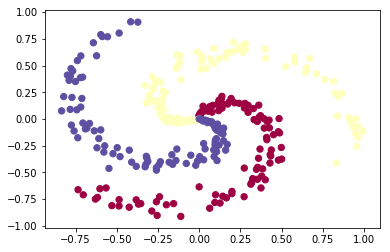

In [63]:
def get_data():
    N = 100 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    return X, y
    
Xdata, ydata = get_data()
print(Xdata.shape)
print(ydata.shape)
plt.scatter(Xdata[:, 0], Xdata[:, 1], c=ydata, s=40, cmap=plt.cm.Spectral)
plt.show()


In [ ]:
fnetwork = Loss(ydata, NN(Xdata, Wdata, b), W)
